<a href="https://colab.research.google.com/github/whsu2s/vision/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoencoder
* Resources:

[1] https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

[2] https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gzip
import string

from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11100365425881336321
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10347478382052956618
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


### Extract data from file

In [2]:
def extract_data(filename, num_img):
  with gzip.open(filename) as bytestream:
    bytestream.read(16)
    buf = bytestream.read(28 * 28 * num_img)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_img, 28, 28)
    return data

train_data = extract_data('data/train-images-idx3-ubyte.gz', 6000)
test_data = extract_data('data/t10k-images-idx3-ubyte.gz', 1000)

In [3]:
train_data.shape

(6000, 28, 28)

In [4]:
def extract_label(filename, num_img):
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1 * num_img)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

train_labels = extract_label('data/train-labels-idx1-ubyte.gz', 6000)
test_labels = extract_label('data/t10k-labels-idx1-ubyte.gz', 1000)

In [5]:
labels = {}
characters = string.ascii_uppercase[:10]
for i in range(10):
  labels[i] = characters[i]
print(labels)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}


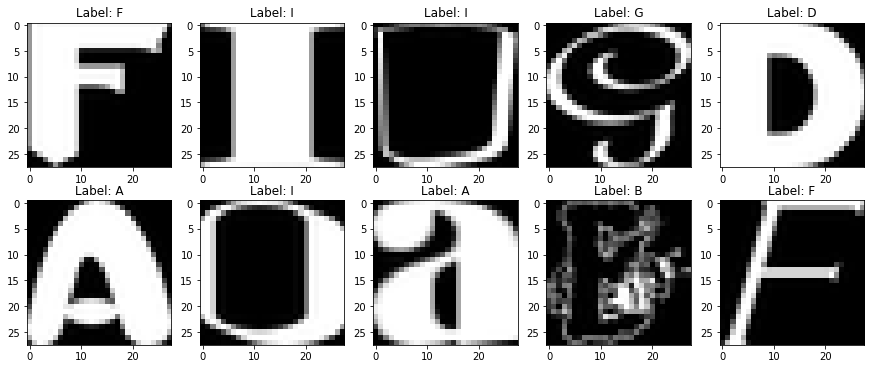

In [45]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
idx = 0

for img, ax in zip(train_data[:10], axs):
  ax.imshow(img, cmap='gray')
  ax.set_title(f'Label: {labels[train_labels[idx]]}')
  idx += 1


### Data preprocessing

In [6]:
# Reshape: num_img * img_width * img_height * channel
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)

In [7]:
# Normalization
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

np.max(train_data)

1.0

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_data, test_size=0.2)
print(f'{len(X_train)} training images and {len(X_val)} validation images.') 

4800 training images and 1200 validation images.


In [ ]:
plt.hist(y_train, bins=10)

### Model training

In [9]:
# Hyper-parameters
batch_size = 128
epochs = 20
input_img = Input(shape=(28, 28, 1))

In [14]:
def conv_autoencoder(input_img):
  """
      arg: input_img with size 28 * 28 * 1
  """
  # Encoder
  conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)  # 28*28*16
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # 14*14*16
  conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)  # 14*14*32
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # 7*7*64
  conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)  # 7*7*64
  encoded = conv3

  # Decoder
  conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)  # 7*7*64
  up1 = UpSampling2D((2, 2))(conv4)  # 14*14*128
  conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)  # 14*14*32
  up2 = UpSampling2D((2, 2))(conv5)  # 28*28*64
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)  # 28*28*1

  return decoded

autoencoder = Model(input_img, conv_autoencoder(input_img))
autoencoder.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 64)          3692

In [27]:
autoencoder.layers[5].output.get_shape

<bound method KerasTensor.get_shape of <KerasTensor: shape=(None, 7, 7, 64) dtype=float32 (created by layer 'conv2d_26')>>

In [15]:
train_history = autoencoder.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=batch_size, 
                                epochs=epochs,
                                shuffle=True)

Epoch 1/20
38/38 [==============================] - 8s 22ms/step - loss: 0.5489 - accuracy: 0.4587 - val_loss: 0.2882 - val_accuracy: 0.5690
Epoch 2/20
38/38 [==============================] - 0s 8ms/step - loss: 0.2706 - accuracy: 0.5739 - val_loss: 0.2326 - val_accuracy: 0.5803
Epoch 3/20
38/38 [==============================] - 0s 11ms/step - loss: 0.2242 - accuracy: 0.5840 - val_loss: 0.2114 - val_accuracy: 0.5841
Epoch 4/20
38/38 [==============================] - 0s 8ms/step - loss: 0.2111 - accuracy: 0.5836 - val_loss: 0.1972 - val_accuracy: 0.5864
Epoch 5/20
38/38 [==============================] - 0s 8ms/step - loss: 0.1942 - accuracy: 0.5886 - val_loss: 0.1885 - val_accuracy: 0.5876
Epoch 6/20
38/38 [==============================] - 0s 8ms/step - loss: 0.1849 - accuracy: 0.5906 - val_loss: 0.1824 - val_accuracy: 0.5884
Epoch 7/20
38/38 [==============================] - 0s 8ms/step - loss: 0.1827 - accuracy: 0.5887 - val_loss: 0.1778 - val_accuracy: 0.5890
Epoch 8/20
38/38 [

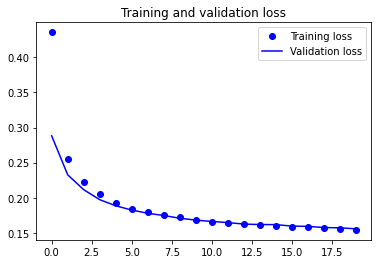

In [16]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
pred = autoencoder.predict(test_data)
pred.shape

(1000, 28, 28, 1)

In [42]:
test_data.shape

(1000, 28, 28, 1)

Test Images


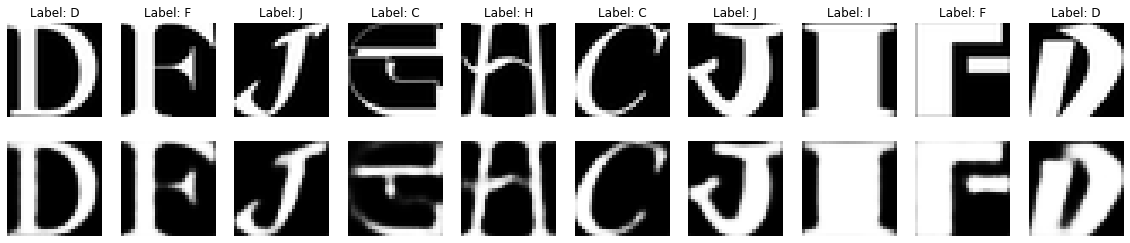

In [21]:
n = 10
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    # Original images
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    i_label = test_labels[i]
    ax.set_title(f"Label: {str(labels[i_label])}")
    ax.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, 10, n+i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
    ax.axis('off')
plt.show()    

In [39]:
# Encoded representations
encoder = Model(input_img, autoencoder.layers[5].output)
encoded_imgs = encoder.predict(test_data)

plt.figure(figsize=(20, 4))
plt.imshow(encoded_imgs[0].reshape((7, 7 * 64)), cmap='gray')
plt.axis('off')
plt.show()

In [48]:
from keras.datasets import fashion_mnist
# load dataset
(X_trainf, y_trainf), (X_testf, y_testf) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [49]:
X_trainf.shape

(60000, 28, 28)

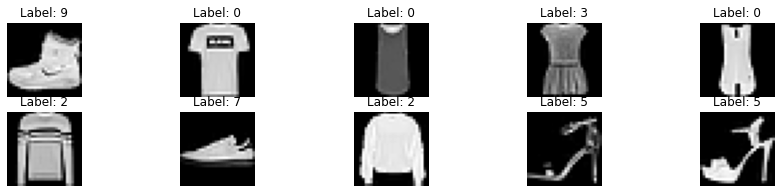

In [51]:
fig, axs = plt.subplots(2, 5, figsize=(15, 3))
axs = axs.flatten()
idx = 0

for img, ax in zip(X_trainf[:10], axs):
  ax.imshow(img, cmap='gray')
  ax.set_title(f'Label: {y_trainf[idx]}')
  ax.axis('off')
  idx += 1

In [52]:
predf = autoencoder.predict(X_testf)
predf.shape

(10000, 28, 28, 1)

Test Images


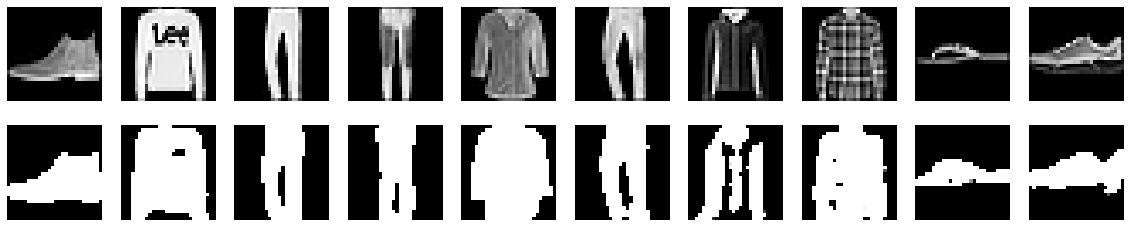

In [55]:
n = 10
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    # Original images
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(X_testf[i, ...], cmap='gray')
    ax.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, 10, n+i+1)
    plt.imshow(predf[i, ..., 0], cmap='gray')  
    ax.axis('off')
plt.show() 